## Import python packages

In [1]:
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
from dask.distributed import Client
import pprint 
%run /home/jovyan/escience-2022/Tjaernoe2022-group2/notebooks/functions.ipynb
%matplotlib inline

In [2]:
client = Client()   # create a local dask cluster on the local machine.
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 62.81 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34993,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 62.81 GiB
Comm: tcp://127.0.0.1:37579,Total threads: 4
Dashboard: http://127.0.0.1:43493/status,Memory: 15.70 GiB
Nanny: tcp://127.0.0.1:33551,


In [77]:
client.close()

## Create weights

In [3]:
def computeWeightedMean(ds):
    # Compute weights based on the xarray you pass
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    # Compute weighted mean
    air_weighted = ds.weighted(weights)
    weighted_mean = air_weighted.mean(("lon", "lat"), keep_attrs=True)
    return weighted_mean

## Open CMIP6 online catalog & download desired data

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
waccm = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1'])
cam = col.search(source_id=['CESM2'], experiment_id=['historical'], table_id=['Amon'], variable_id=['o3'], member_id=['r1i1p1f1'])
cam.df
waccm.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCAR,CESM2-WACCM,historical,r1i1p1f1,Amon,o3,gn,gs://cmip6/CMIP6/CMIP/NCAR/CESM2-WACCM/histori...,NaN,20190415


In [6]:
col = col.search(source_id=['CESM2-WACCM'], experiment_id=['historical'], table_id=['Amon'], member_id=['r1i1p1f1'])
 
uni_dict = col.unique(['variable_id'])
pprint.pprint(uni_dict, compact=True)
#areacella

{'variable_id': {'count': 51,
                 'values': ['co2mass', 'prc', 'rsds', 'ts', 'n2o', 'rsus',
                            'rtmt', 'huss', 'hfss', 'va', 'n2oglobal', 'clivi',
                            'hfls', 'pr', 'ch4', 'clw', 'clt', 'cfc11global',
                            'ta', 'ps', 'evspsbl', 'tas', 'rsut', 'rldscs',
                            'cfc12global', 'rsdscs', 'rsutcs', 'hus', 'o3',
                            'tauv', 'sfcWind', 'wap', 'rlds', 'prw', 'zg',
                            'clwvi', 'tauu', 'ua', 'rsuscs', 'rsdt', 'hur',
                            'rlus', 'co2', 'psl', 'sbl', 'rlutcs', 'cli', 'ci',
                            'hurs', 'rlut', 'cl']}}


## Create dictionary from the list of datasets you want

In [5]:
ds_dict_waccm = waccm.to_dataset_dict(zarr_kwargs={'use_cftime':True})
ds_dict_cam = cam.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
print(list(ds_dict_waccm.keys()))
print(list(ds_dict_cam.keys()))
ds_waccm = ds_dict_waccm['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
ds_cam = ds_dict_cam['CMIP.NCAR.CESM2.historical.Amon.gn']

['CMIP.NCAR.CESM2-WACCM.historical.Amon.gn']
['CMIP.NCAR.CESM2.historical.Amon.gn']


In [35]:
#ds_waccm.to_netcdf(path='/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/ds_waccm.nc', mode='w',format='NETCDF4_CLASSIC')
#ds_cam.to_netcdf(path='/home/jovyan/escience-2022/Tjaernoe2022-group2/Emma/ds_cam.nc', mode='w',format='NETCDF4_CLASSIC')

## Select time period 

In [27]:
ds_waccm.o3.chunksizes

Frozen({'member_id': (1,), 'time': (60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60), 'plev': (19,), 'lat': (192,), 'lon': (288,)})

In [7]:
start = cftime.DatetimeNoLeap(1985,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
ds_waccm_1986_1996 = ds_waccm.sel(time=slice(start, end))
# CAM
ds_cam_1986_1996 = ds_cam.sel(time=slice(start, end))

In [33]:
#ds_waccm_1986_1996.to_netcdf(path='/home/jovyan/escience-2022/Tjaernoe2022-group2/ds_waccm_1986_1996.nc', mode='w',format='NETCDF4_CLASSIC')
#ds_cam_1986_1996.to_netcdf(path='/home/jovyan/escience-2022/Tjaernoe2022-group2/ds_cam_1986_1996.nc', mode='w',format='NETCDF4_CLASSIC')

## Calculate ozone from concentration to Dobson units

In [11]:
# Creates a new variable called totO3 for WACCM and CAM 
ds_waccm_1986_1996 = calculate_total_ozone_p(ds_waccm_1986_1996)
ds_cam_1986_1996 = calculate_total_ozone_p(ds_cam_1986_1996)

Minimum column ozone value: 77.58066507113938
Minimum column ozone value: 123.06982718972165


## Compute the weighted mean concentration for the whole period 1859 - 2014
## Plot WACCM and CAM in the northern and southern hemisphere for comparison

In [42]:
# Northern hemisphere
weighted_mean_cam = computeWeightedMean(ds_cam.o3.where(ds_cam.o3['lat']>60.)).squeeze().sum('plev').compute()
weighted_mean_waccm = computeWeightedMean(ds_waccm.o3.where(ds_waccm.o3['lat']>60.)).squeeze().sum('plev').compute()

# Southern hemisphere
weighted_mean_cam_south = computeWeightedMean(ds_cam.o3.where(ds_cam.o3['lat']<-60.)).squeeze().sum('plev').compute()
weighted_mean_waccm_south = computeWeightedMean(ds_waccm.o3.where(ds_waccm.o3['lat']<-60.)).squeeze().sum('plev').compute()


2022-11-04 18:43:33,903 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:32971 -> tcp://127.0.0.1:39935
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/distributed/nanny.py", line 910, in _run
    loop.run_sync(run)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
    self._run_once()
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
    handle._run()
  File "/srv/conda/envs/notebook/lib/python3.9/asyncio/events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/python3.9/site-packages/tornado/ioloop.p

KeyboardInterrupt: 

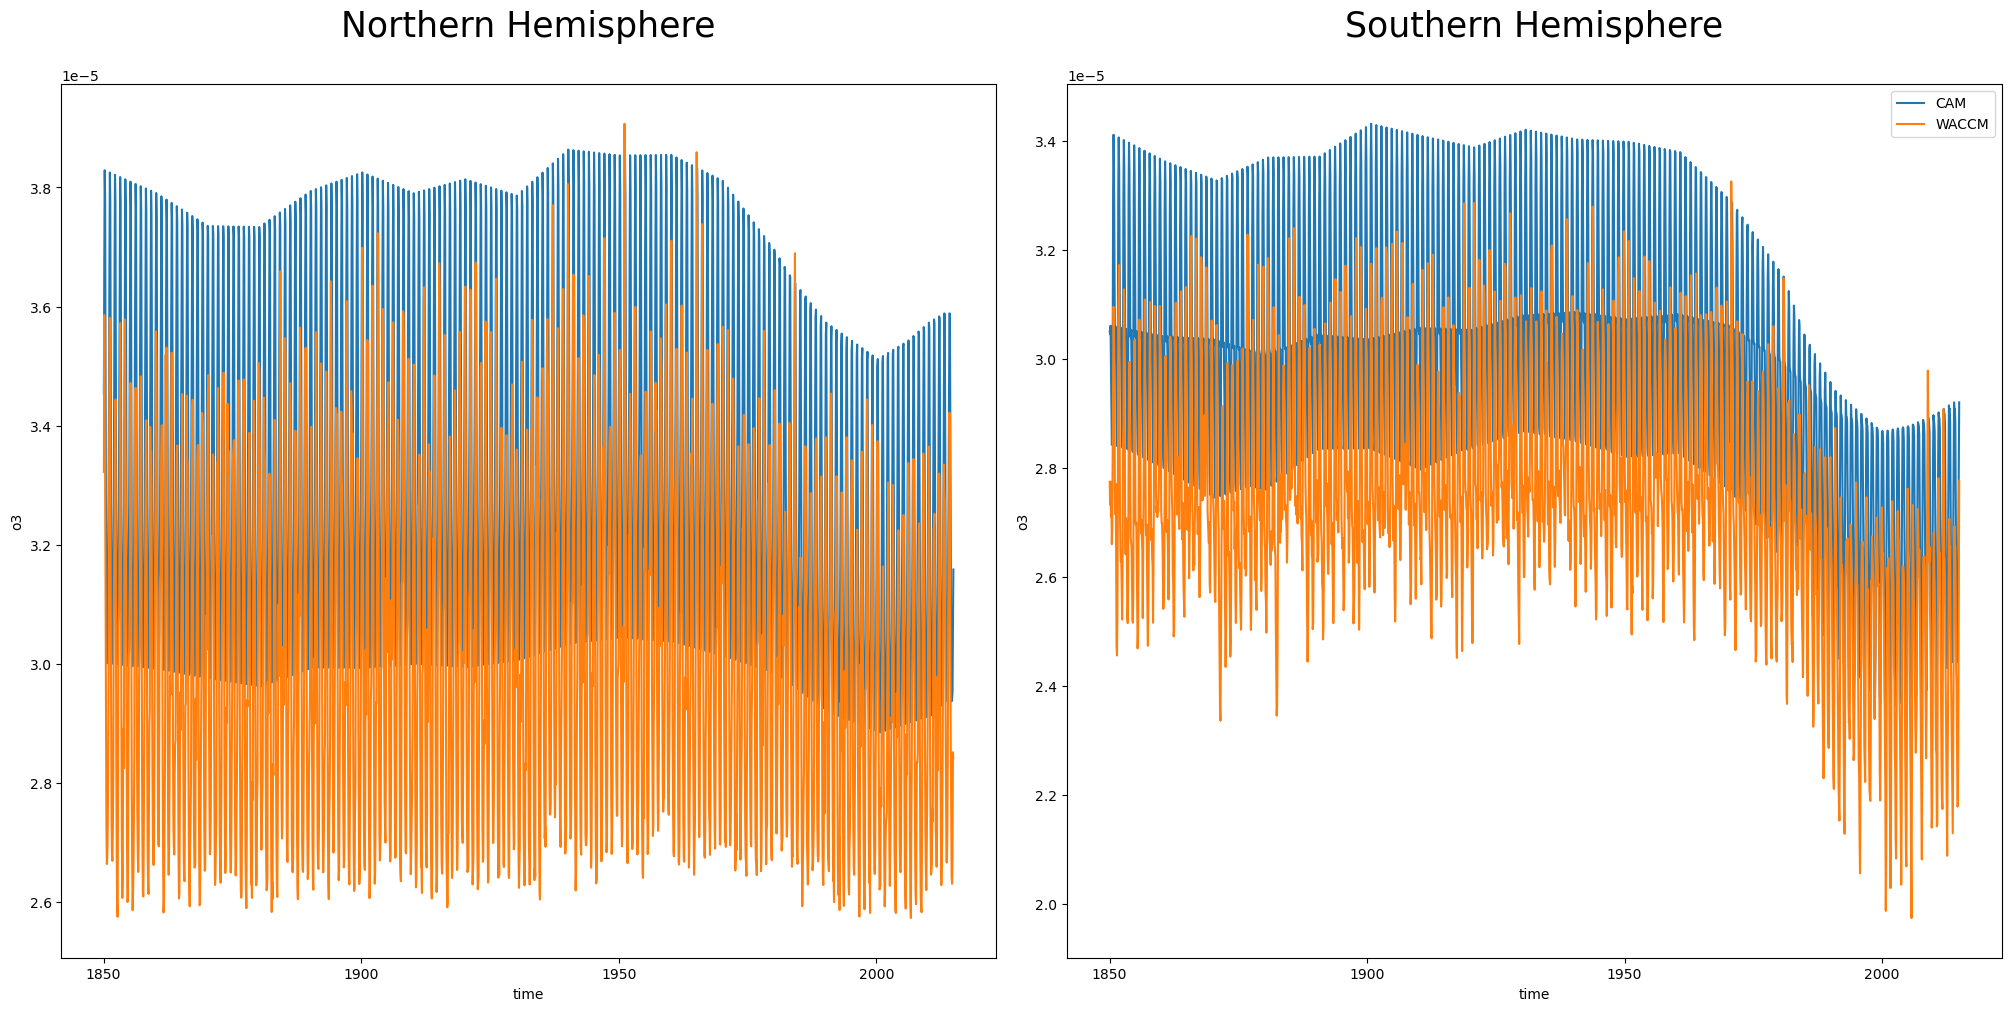

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))

weighted_mean_cam.plot(label="CAM", ax=ax1)
weighted_mean_waccm.plot(label="WACCM", ax=ax1)

weighted_mean_cam_south.plot(label="CAM", ax=ax2)
weighted_mean_waccm_south.plot(label="WACCM", ax=ax2)

ax1.set_title(" Northern Hemisphere \n" , fontsize=25)
ax2.set_title(" Southern Hemisphere \n" , fontsize=25)
plt.legend()

## Compute the weighted mean concentration for the period 1986 - 1996

## Plot WACCM and CAM in the northern and southern hemisphere for comparison

In [46]:
# Northern hemisphere
weighted_mean_cam_north_timeslice = computeWeightedMean(ds_cam_1986_1996.o3.where(ds_cam_1986_1996.o3['lat']>60.)).squeeze().sum('plev').compute()
weighted_mean_waccm_north_timeslice = computeWeightedMean(ds_waccm_1986_1996.o3.where(ds_waccm_1986_1996.o3['lat']>60.)).squeeze().sum('plev').compute()

# Southern hemisphere
weighted_mean_cam_south_timeslice = computeWeightedMean(ds_cam_1986_1996.o3.where(ds_cam_1986_1996.o3['lat']<-60.)).squeeze().sum('plev').compute()
weighted_mean_waccm_south_timeslice = computeWeightedMean(ds_waccm_1986_1996.o3.where(ds_waccm_1986_1996.o3['lat']<-60.)).squeeze().sum('plev').compute()



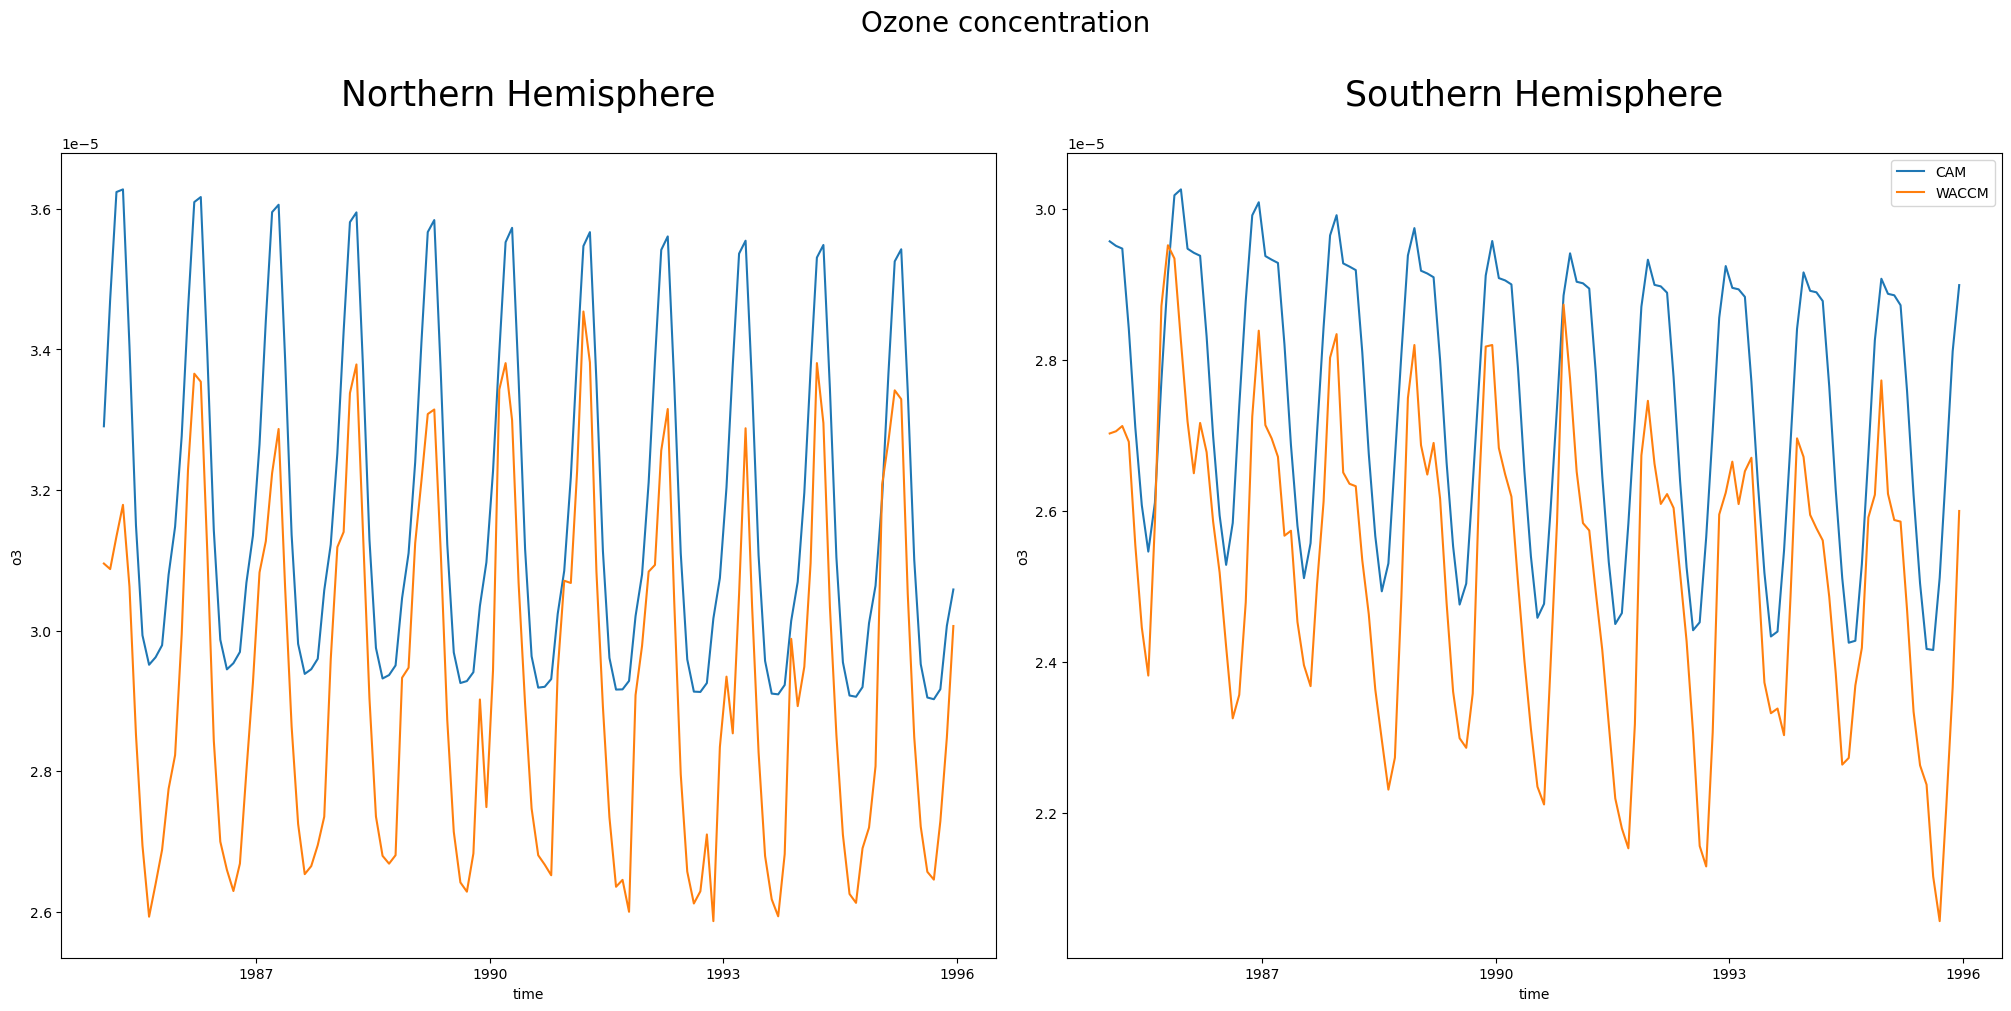

In [47]:
fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))
#fig, ax = plt.figure(1, figsize=[20,10])
weighted_mean_cam_north_timeslice.plot(label="CAM", ax=axs1)
weighted_mean_waccm_north_timeslice.plot(label="WACCM", ax=axs1)

weighted_mean_cam_south_timeslice.plot(label="CAM", ax=axs2)
weighted_mean_waccm_south_timeslice.plot(label="WACCM", ax=axs2)

fig.suptitle('Ozone concentration\n', fontsize=20)

axs1.set_title(" Northern Hemisphere \n" , fontsize=25)
axs2.set_title(" Southern Hemisphere \n" , fontsize=25)
plt.legend()



## Calculate the anomaly 
## Plot WACCM and CAM in the northern and southern hemisphere for comparison

In [ ]:
# no.1
# mean of every month for 30 years = climatology
# calculate anomaly = orig - climatology
# this gets rid of the the flux

#no.2
# calc mean of 5 years before the eruption 
# calc anomaly = (5 year prior & 5 year after) - mean(5 year prior)

In [28]:
ds_cam_post_eruption

<xarray.DataArray 'totO3' (year: 11, lat: 192, lon: 288)>
dask.array<transpose, shape=(11, 192, 288), dtype=float64, chunksize=(1, 192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    member_id  <U8 'r1i1p1f1'
  * year       (year) int64 1985 1986 1987 1988 1989 ... 1992 1993 1994 1995
Attributes:
    units:      DU
    long_name:  Column ozone in Dobson Units

In [25]:
# Select 5 years post volcanic eruption to see the effect on the ozone
end_prior_eruption = cftime.DatetimeNoLeap(1991,1,15)
start = cftime.DatetimeNoLeap(1985,1,15)
end = cftime.DatetimeNoLeap(1996,1,15)

# WACCM
ds_waccm_post_eruption = ds_waccm_1986_1996['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_waccm_climatology = ds_waccm_1986_1996['totO3'].sel(time=slice(start,end_prior_eruption)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_waccm_anomaly = ds_waccm_post_eruption - ds_waccm_climatology
ds_waccm_anomaly.attrs = ds_waccm_climatology.attrs

# CAM
ds_cam_post_eruption = ds_cam_1986_1996['totO3'].squeeze().groupby('time.year').mean('time', keep_attrs=True)
ds_cam_climatology = ds_cam_1986_1996['totO3'].sel(time=slice(start,end_prior_eruption)).squeeze().groupby('time.year').mean('time', keep_attrs=True).mean('year', keep_attrs=True)
ds_cam_anomaly = ds_cam_post_eruption - ds_cam_climatology
ds_cam_anomaly.attrs = ds_cam_climatology.attrs

In [29]:
# Calculate the weight for the northern and southern hemispheres
# WACCM
waccm_weight_north_anomaly = computeWeightedMean(ds_waccm_anomaly.where(ds_waccm_anomaly['lat']>60.)).compute()
waccm_weight_south_anomaly = computeWeightedMean(ds_waccm_anomaly.where(ds_waccm_anomaly['lat']<-60.)).compute()

# CAM
cam_weight_north_anomaly = computeWeightedMean(ds_cam_anomaly.where(ds_cam_anomaly['lat']>60.)).compute()
cam_weight_south_anomaly = computeWeightedMean(ds_cam_anomaly.where(ds_cam_anomaly['lat']<-60.)).compute()

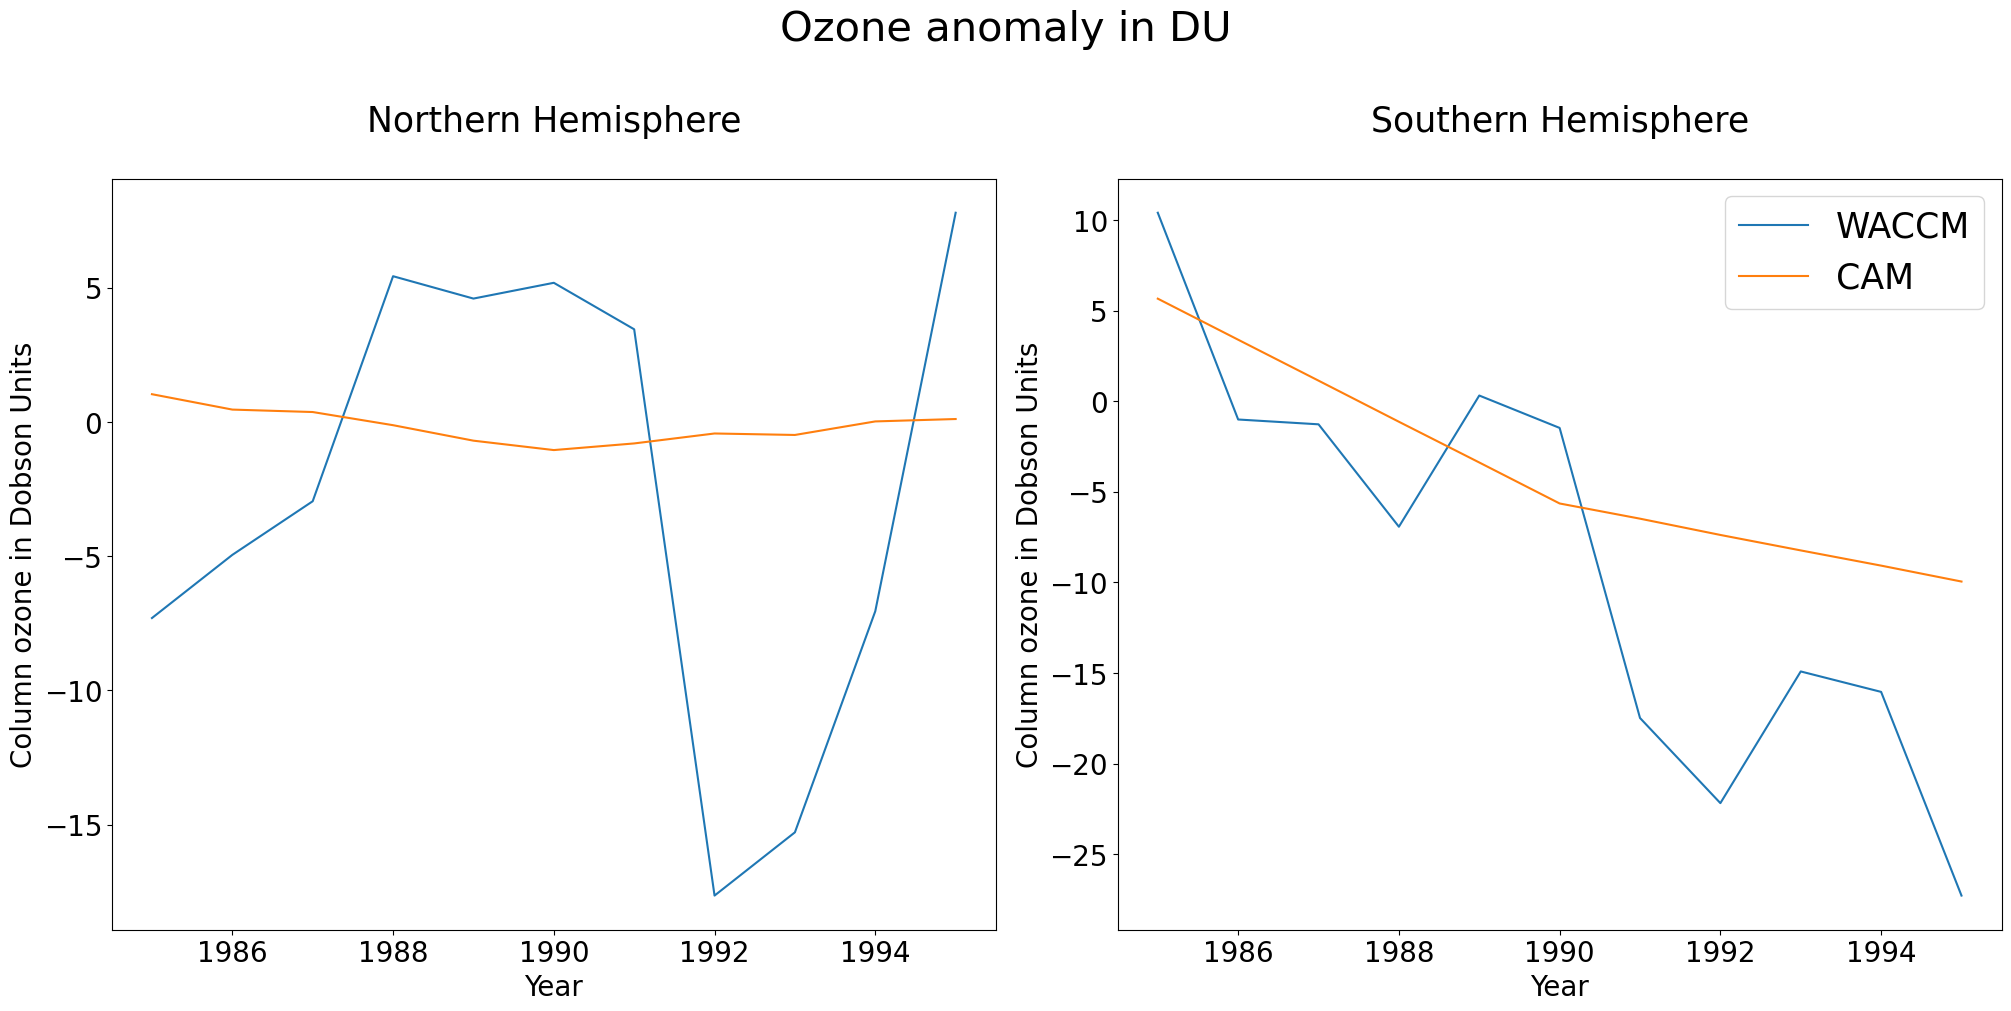

In [30]:
fig, (axs1, axs2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20,10))

#w_m_w_n_anomaly.sel(time=slice(start,end)).plot(label="CAM", ax=axs1)
waccm_weight_north_anomaly.plot(label="WACCM", ax=axs1)
cam_weight_north_anomaly.plot(label="CAM", ax=axs1)
#plt.legend()

#w_m_w_south_anomaly.sel(time=slice(start,end)).plot(label="CAM", ax=axs2)
waccm_weight_south_anomaly.plot(label="WACCM", ax=axs2)
cam_weight_south_anomaly.plot(label="CAM", ax=axs2)

fig.suptitle('Ozone anomaly in DU\n', fontsize=30)

axs1.set_ylabel(waccm_weight_south_anomaly.long_name, fontsize=20)
axs2.set_ylabel(cam_weight_south_anomaly.long_name, fontsize=20)

axs1.set_xlabel('Year', fontsize=20)
axs2.set_xlabel('Year', fontsize=20)

axs1.tick_params(axis="x", labelsize=20)
axs2.tick_params(axis="x", labelsize=20)

axs1.tick_params(axis="y", labelsize=20)
axs2.tick_params(axis="y", labelsize=20)

axs1.set_title(" Northern Hemisphere \n" , fontsize=25)
axs2.set_title(" Southern Hemisphere \n" , fontsize=25)

plt.legend(fontsize=25)

In [36]:
client.close()